In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [ ]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_fixed")
features = ["game_completed", "relative_strength", "score_difference", "type.id", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML


In [34]:
# Reset the modules
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

import process_data
training_data = process_data.load_data(interpolated_dir, 
                                       years = [2016, 2017,2018, 2019, 2020, 2021, 2022], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

validation_data = process_data.load_data(interpolated_dir, 
                                       years = [2023], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = True
                                       )

test_data = process_data.load_data(interpolated_dir, 
                                       years = [2024],
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = False
                                       )


Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2017/game_400951752.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2017/game_400951752.csv
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2019/game_401127989.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2019/game_401127963.csv
  NaN foun

In [35]:
# Get information about the data
training_data = dict(sorted(training_data.items()))
for timestep in training_data:
    print(f"timestep: {timestep}, number of instances: {len(training_data[timestep])}")

timestep: 0.0, number of instances: 3244
timestep: 0.005, number of instances: 1142
timestep: 0.01, number of instances: 2157
timestep: 0.015, number of instances: 1805
timestep: 0.02, number of instances: 2016
timestep: 0.025, number of instances: 2086
timestep: 0.03, number of instances: 1976
timestep: 0.035, number of instances: 2157
timestep: 0.04, number of instances: 2047
timestep: 0.045, number of instances: 2177
timestep: 0.05, number of instances: 2126
timestep: 0.055, number of instances: 2038
timestep: 0.06, number of instances: 2220
timestep: 0.065, number of instances: 2157
timestep: 0.07, number of instances: 2181
timestep: 0.075, number of instances: 2135
timestep: 0.08, number of instances: 2193
timestep: 0.085, number of instances: 2211
timestep: 0.09, number of instances: 2122
timestep: 0.095, number of instances: 2207
timestep: 0.1, number of instances: 2178
timestep: 0.105, number of instances: 2161
timestep: 0.11, number of instances: 2234
timestep: 0.115, number o

In [36]:
for timestep in test_data:
    print(f"timestep: {timestep}, number of instances: {len(test_data[timestep])}")

timestep: 0.0, number of instances: 276
timestep: 0.005, number of instances: 300
timestep: 0.01, number of instances: 281
timestep: 0.015, number of instances: 306
timestep: 0.02, number of instances: 289
timestep: 0.025, number of instances: 315
timestep: 0.03, number of instances: 305
timestep: 0.035, number of instances: 318
timestep: 0.04, number of instances: 336
timestep: 0.045, number of instances: 311
timestep: 0.05, number of instances: 335
timestep: 0.055, number of instances: 364
timestep: 0.06, number of instances: 333
timestep: 0.065, number of instances: 334
timestep: 0.07, number of instances: 338
timestep: 0.075, number of instances: 342
timestep: 0.08, number of instances: 342
timestep: 0.085, number of instances: 334
timestep: 0.09, number of instances: 359
timestep: 0.095, number of instances: 357
timestep: 0.1, number of instances: 353
timestep: 0.105, number of instances: 342
timestep: 0.11, number of instances: 346
timestep: 0.115, number of instances: 341
timest

In [82]:
other_features = [
            "type.id",             # Play type (categorical)
            "home_has_possession", # Binary indicator
            "end.down",            # Down number (1-4, discrete)
            "home_timeouts_left",  # Discrete count (0-3)
            "away_timeouts_left",  # Discrete count (0-3)
            "game_completed"
        ]
numeric_features = [
    "score_difference",
    "relative_strength", 
    "end.yardsToEndzone", 
    "end.distance", 
    "field_position_shift"
]

In [83]:
# Setup model for each timestep
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# create an array of logistic regression models

modules_to_reload = [
    'models.logistic_regression',
    'models.Model'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
from models.Model import Model
from models.logistic_regression import setup_logistic_regression_models

models = setup_logistic_regression_models(training_data, validation_data, numeric_features, other_features, features, optimize_hyperparams=False, use_calibration=False)


Processing timestep: 0.0
Timestep 0.00% : Training Loss = 0.6236, Accuracy = 0.6492, Test Loss = 0.6401, Test Accuracy = 0.6407
Processing timestep: 0.005
Timestep 0.50% : Training Loss = 0.6242, Accuracy = 0.6401, Test Loss = 0.7024, Test Accuracy = 0.5403
Processing timestep: 0.01
Timestep 1.00% : Training Loss = 0.6165, Accuracy = 0.6514, Test Loss = 0.6484, Test Accuracy = 0.6177
Processing timestep: 0.015
Timestep 1.50% : Training Loss = 0.6260, Accuracy = 0.6449, Test Loss = 0.6509, Test Accuracy = 0.6285
Processing timestep: 0.02
Timestep 2.00% : Training Loss = 0.6261, Accuracy = 0.6478, Test Loss = 0.6766, Test Accuracy = 0.6125
Processing timestep: 0.025
Timestep 2.50% : Training Loss = 0.6318, Accuracy = 0.6433, Test Loss = 0.6317, Test Accuracy = 0.6551
Processing timestep: 0.03
Timestep 3.00% : Training Loss = 0.6145, Accuracy = 0.6675, Test Loss = 0.6520, Test Accuracy = 0.6267
Processing timestep: 0.035
Timestep 3.50% : Training Loss = 0.6217, Accuracy = 0.6458, Test Los

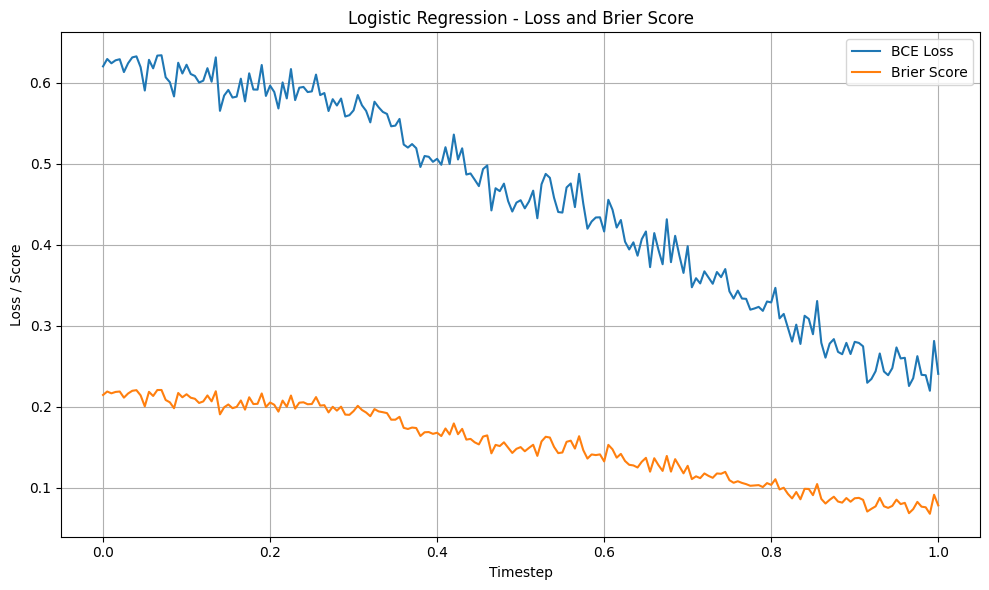

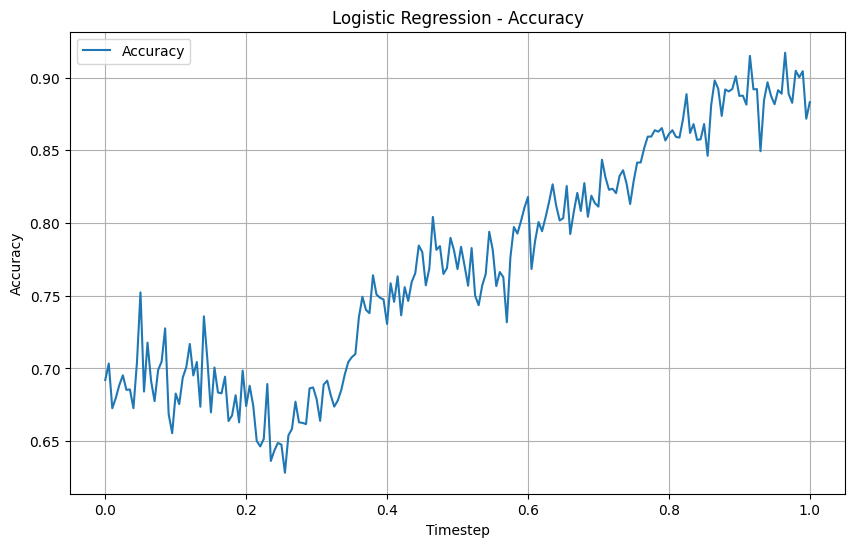

In [8]:
# # Test accuracy of model for each timestep on test data and plot
# accuracies = []
# timesteps = []
import process_data
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

x = process_data.plot_loss(models, test_data, "Logistic Regression")
process_data.plot_accuracy(models, test_data, "Logistic Regression")

In [156]:
# Save the model
import pickle
filename = 'logistic_regression_model.pickle'
pickle.dump(models, open(filename, 'wb'))

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


game_completed: 5.396734613814907
relative_strength: 0.3019469863268509
score_difference: 0.13817650420544478
type.id: 0.035147177629642735
home_has_possession: -0.012738740138944158
end.down: 0.006880590576059864
end.yardsToEndzone: 1.849786044864974
end.distance: 0.0028837019873012015
field_position_shift: 0.18987958373766622
home_timeouts_left: -0.21213056295314972
away_timeouts_left: -0.271412938475227


PermutationExplainer explainer: 415it [00:14, 10.11it/s]                         


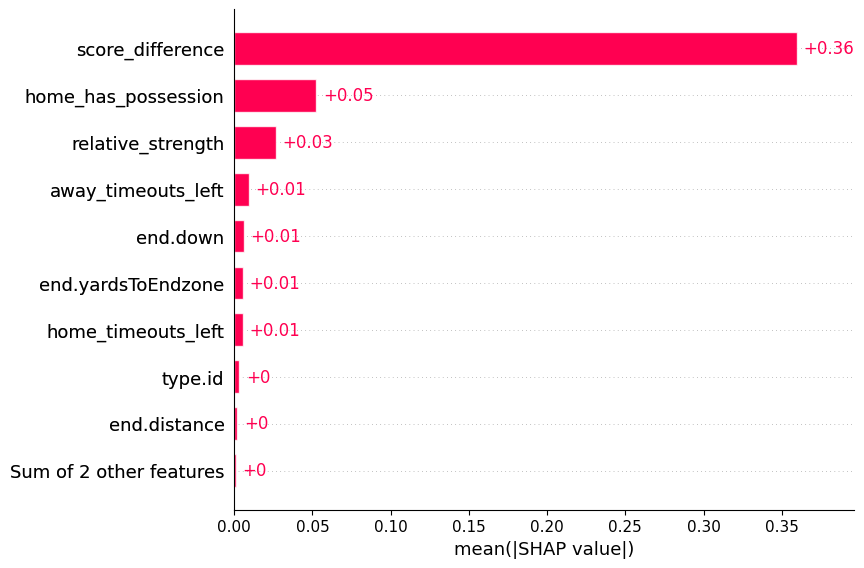

.values =
array([[ 6.76476767e-05, -6.80018330e-02, -1.92185919e-01, ...,
         4.41363560e-03,  7.97554634e-03, -3.87074124e-03],
       [-1.46824033e-05, -8.07073565e-02, -1.36960190e-01, ...,
         4.65687965e-05,  1.00628080e-02, -4.77603862e-03],
       [-1.28290021e-05, -1.12945829e-03, -5.01388026e-01, ...,
         1.21437099e-04,  2.57612472e-03, -2.14515665e-03],
       ...,
       [ 1.70718747e-04, -6.30483866e-02,  2.58037919e-01, ...,
         3.24275039e-05,  8.19530243e-03,  1.62135725e-02],
       [ 3.26878880e-05, -3.67892075e-02,  4.30929108e-01, ...,
         5.91039885e-04,  6.94932453e-03,  1.19835622e-02],
       [ 3.75946011e-05,  5.67386851e-02,  1.29852226e-01, ...,
        -2.95659431e-04,  9.80334316e-03,  1.74563916e-02]])

.base_values =
array([0.48327108, 0.48327108, 0.48327108, 0.48327108, 0.48327108,
       0.48327108, 0.48327108, 0.48327108, 0.48327108, 0.48327108,
       0.48327108, 0.48327108, 0.48327108, 0.48327108, 0.48327108,
       0.4832710

In [111]:
%reload_ext autoreload
from models.utils import SHAP_analysis
model = models[0.99]
# Health Check:
if hasattr(model.model, "coef_"):
    feature_names = model.all_features if hasattr(model, "all_features") else None
    coefs = model.model.coef_[0]  # shape (n_features,)
    if feature_names is not None and len(feature_names) == len(coefs):
        for name, coef in zip(feature_names, coefs):
            print(f"{name}: {coef}")


SHAP_analysis(models, 0.95, training_data, test_data)
# x = np.array([[0.1, 0.9, 20, 1, 0, 1, 50, 20, 2, 2, 2]])
# model.predict_proba(x)


In [ ]:
from process_data import write_predictions

write_predictions(models, interpolated_dir, [2024], 0, features, replace_nan_val = 0, phat_b = "LR_phat_b_model_no_type")

# For Debugging Purposes